In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.preprocessing import normalize

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
import jpype
import jpype.imports
from jpype.types import *
jpype.startJVM()

In [3]:
# Add java class file, make sure the jar file under the 'src' floder 
jpype.addClassPath('./GTTransport/src/optimaltransport.jar')
from optimaltransport import Mapping

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False,
    transform = ToTensor()
)

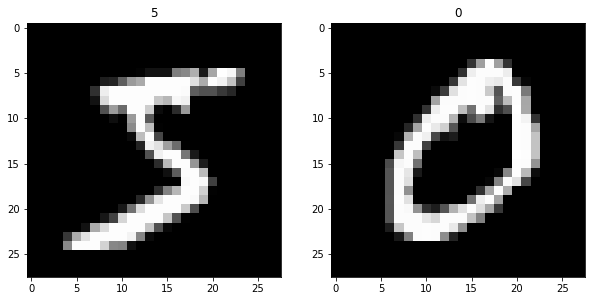

In [5]:
figure = plt.figure(figsize=(10, 8))
figure.add_subplot(1, 2, 1)
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
figure.add_subplot(1, 2, 2)
plt.imshow(train_data.data[1], cmap='gray')
plt.title('%i' % train_data.targets[1])
plt.show()

In [6]:
def computeDistanceMatrixGrid(size):
    size = train_data[0][0][0].size()
    A = np.zeros([size[0]*size[1],2])
    itr = 0
    for i in range(size[0]):
        for j in range(size[1]):
            itr = itr + 1
            A[itr-1, 0] = i+1
            A[itr-1, 1] = j+1
    M = cdist(A,A,metric='sqeuclidean')
    return M

In [7]:
# normailize the input cost matrix by max value
image1 = train_data[0][0][0]
image2 = train_data[1][0][0]
C = computeDistanceMatrixGrid(image1.size())
C = C/np.max(C)

In [8]:
# normailize the input demand/supply by sum value
image1 = image1.flatten()
image2 = image2.flatten()
image1 = image1 / torch.sum(image1)
image2 = image2 / torch.sum(image2)
image1[image1==0] = 0.000001
image1[image1==0] = 0.000001
image1 = image1 / torch.sum(image1)
image2 = image2 / torch.sum(image2)

In [9]:
deltas = [0.1, 0.01, 0.001]
n = image1.size(0)

In [10]:
# Construct Mapping object and calculate OT
gtSolver = Mapping(n, np.float64(image1.numpy()), np.float64(image2.numpy()), C, deltas[1])

In [15]:
# Call methods in Mapping class
flow = np.array(gtSolver.getFlow());
total_cost_transport = gtSolver.getTotalCost();
iterationCountTransport = gtSolver.getIterations();
APLengths = gtSolver.getAPLengths();
augmentTime = gtSolver.getTimeTakenAugment();
APinfo = np.array(gtSolver.getAPinfo());
inter_flow_step = gtSolver.getStopStep();
dual = np.array(gtSolver.getDual());

In [33]:
flow_log = np.array(gtSolver.getFlowLog(5))